## Prepare Dataset

### Flow count for VPN and non-VPN

label
NoVPN    43597
VPN       8350
Name: count, dtype: int64


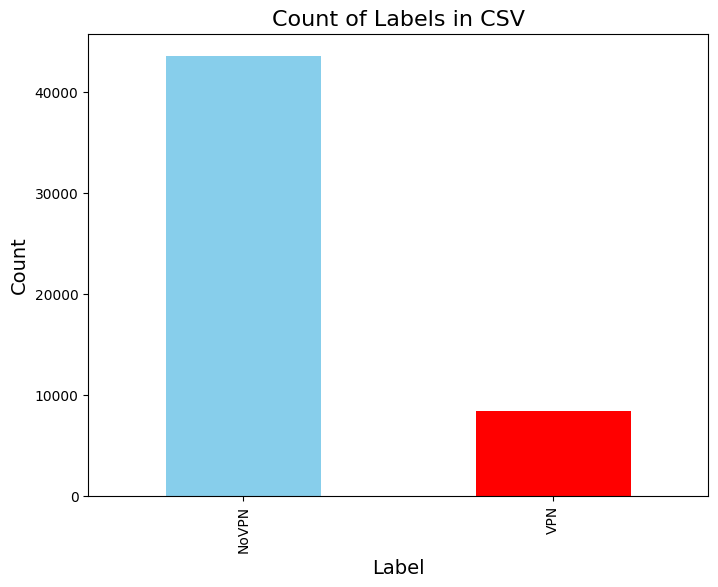

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./VNAT/WF/flows_extra_labelled_5.csv',low_memory=False)

label_counts = df['label'].value_counts()
print(label_counts)

plt.figure(figsize=(8, 6))  
label_counts.plot(kind='bar', color=['skyblue', 'red'])  

plt.title('Count of Labels in CSV', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.show()


### Create a dataset for Wavelet Features

In [1]:
import pandas as pd
import numpy as np

df1 = pd.read_csv('./VNAT/WF/flows_extra_labelled_5.csv',low_memory=False)

columns_to_select = [
                     #select Wavelet features
                     #forward
                    'udps.f_p_k_0','udps.f_p_k_1','udps.f_p_k_2','udps.f_p_k_3','udps.f_p_k_4','udps.f_p_k_5',
                     'udps.f_u_k_0','udps.f_u_k_1','udps.f_u_k_2','udps.f_u_k_3','udps.f_u_k_4','udps.f_u_k_5',
                     'udps.f_sigma_k_0','udps.f_sigma_k_1','udps.f_sigma_k_2','udps.f_sigma_k_3','udps.f_sigma_k_4','udps.f_sigma_k_5',
                     'udps.f_S_k_0','udps.f_S_k_1','udps.f_S_k_2','udps.f_S_k_3','udps.f_S_k_4','udps.f_S_k_5',
                  #backward
                     'udps.b_p_k_0','udps.b_p_k_1','udps.b_p_k_2','udps.b_p_k_3','udps.b_p_k_4','udps.b_p_k_5',
                     'udps.b_u_k_0','udps.b_u_k_1','udps.b_u_k_2','udps.b_u_k_3','udps.b_u_k_4','udps.b_u_k_5',
                     'udps.b_sigma_k_0','udps.b_sigma_k_1','udps.b_sigma_k_2','udps.b_sigma_k_3','udps.b_sigma_k_4','udps.b_sigma_k_5',
                     'udps.b_S_k_0','udps.b_S_k_1','udps.b_S_k_2','udps.b_S_k_3','udps.b_S_k_4','udps.b_S_k_5'
                   , 'label','category']
df_WNF = df1[columns_to_select]                  

df_WNF.to_csv('./VNAT/WF/flows_extra_labelled_WF5.csv', index=False)

### Rndom Forest

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

output_dir = "output_results"
os.makedirs(output_dir, exist_ok=True)

file_path = './VNAT/WF/flows_extra_labelled_WF5.csv'  
df = pd.read_csv(file_path)

df['label_encoded'] = df['label'].map({'NoVPN': 0, 'VPN': 1})

category = df['category']

X = df.drop(['label', 'label_encoded', 'category'], axis=1)
y = df['label_encoded']

X_train, X_test, y_train, y_test, category_train, category_test = train_test_split(
    X, y, category, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, clf.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, normalize='true')

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['NoVPN', 'VPN']))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['non-VPN', 'VPN'], 
yticklabels=['non-VPN', 'VPN'], annot_kws={"size": 16})  

plt.xlabel("Predicted Label", fontsize=20)
plt.ylabel("True Label", fontsize=20)
plt.title("", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

conf_matrix_path = os.path.join(output_dir, "confusion_matrix_RF5.png")
plt.savefig(conf_matrix_path, dpi=300, bbox_inches='tight')
plt.close()

accuracy_report_path = os.path.join(output_dir, "RF5.txt")
with open(accuracy_report_path, "w") as f:
    f.write(f"Train Accuracy: {train_accuracy:.4f}\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=['NoVPN', 'VPN']))

misclassified_mask = (y_test != y_pred)
misclassified_samples = X_test.loc[misclassified_mask].copy()

misclassified_samples['true_label'] = y_test.loc[misclassified_mask]
misclassified_samples['predicted_label'] = y_pred[misclassified_mask]
misclassified_samples['category'] = category_test.loc[misclassified_mask]

label_map = {0: 'NoVPN', 1: 'VPN'}
misclassified_samples['true_label'] = misclassified_samples['true_label'].map(label_map)
misclassified_samples['predicted_label'] = misclassified_samples['predicted_label'].map(label_map)

misclassification_detail = misclassified_samples.groupby(['category', 'true_label', 'predicted_label']).size().reset_index(name='count')

print("\nDetailed Misclassification Summary (per Category):")
print(misclassification_detail)

misclassification_detail_path = os.path.join(output_dir, "RF5.csv")
misclassification_detail.to_csv(misclassification_detail_path, index=False)

print("Confusion matrix saved at:", conf_matrix_path)
print("Accuracy and classification report saved at:", accuracy_report_path)
print("Detailed misclassification summary saved at:", misclassification_detail_path)


Train Accuracy: 0.999975936665303
Test Accuracy: 0.9910490856592877

Confusion Matrix:
[[0.9952987  0.0047013 ]
 [0.03115638 0.96884362]]

Classification Report:
              precision    recall  f1-score   support

       NoVPN       0.99      1.00      0.99      8721
         VPN       0.98      0.97      0.97      1669

    accuracy                           0.99     10390
   macro avg       0.98      0.98      0.98     10390
weighted avg       0.99      0.99      0.99     10390


Detailed Misclassification Summary (per Category):
            category true_label predicted_label  count
0               Chat      NoVPN             VPN     23
1               Chat        VPN           NoVPN     33
2  Command & Control      NoVPN             VPN      4
3  Command & Control        VPN           NoVPN      5
4      File Transfer      NoVPN             VPN      3
5      File Transfer        VPN           NoVPN     10
6          Streaming      NoVPN             VPN     11
7          Streamin

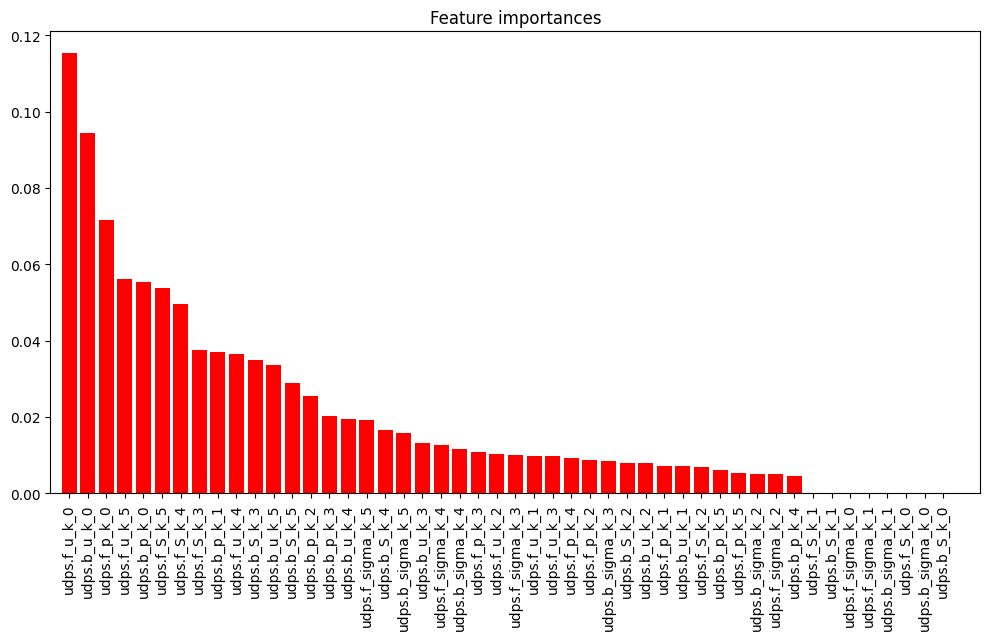

In [7]:
#  feature importances
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]+1])
plt.show()

### SVM

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

output_dir = "output_results"
os.makedirs(output_dir, exist_ok=True)

file_path = './VNAT/WF/flows_extra_labelled_WF5.csv'  
df = pd.read_csv(file_path)

df['label_encoded'] = df['label'].map({'NoVPN': 0, 'VPN': 1})

category = df['category']

X = df.drop(['label', 'label_encoded', 'category'], axis=1)
y = df['label_encoded']

X_train, X_test, y_train, y_test, category_train, category_test = train_test_split(
    X, y, category, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)

clf = LinearSVC(random_state=42, max_iter=10000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, clf.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, normalize='true')

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['NoVPN', 'VPN']))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['NoVPN', 'VPN'], 
yticklabels=['NoVPN', 'VPN'], annot_kws={"size": 16})  # Enlarged numbers inside the matrix

plt.xlabel("Predicted Label", fontsize=20)
plt.ylabel("True Label", fontsize=20)
plt.title("", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

conf_matrix_path = os.path.join(output_dir, "confusion_matrix_SVM5.png")
plt.savefig(conf_matrix_path, dpi=300, bbox_inches='tight')
plt.close()

accuracy_report_path = os.path.join(output_dir, "SVM5.txt")
with open(accuracy_report_path, "w") as f:
    f.write(f"Train Accuracy: {train_accuracy:.4f}\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=['NoVPN', 'VPN']))

misclassified_mask = (y_test != y_pred)
misclassified_samples = X_test.loc[misclassified_mask].copy()

misclassified_samples['true_label'] = y_test.loc[misclassified_mask]
misclassified_samples['predicted_label'] = y_pred[misclassified_mask]
misclassified_samples['category'] = category_test.loc[misclassified_mask]

label_map = {0: 'NoVPN', 1: 'VPN'}
misclassified_samples['true_label'] = misclassified_samples['true_label'].map(label_map)
misclassified_samples['predicted_label'] = misclassified_samples['predicted_label'].map(label_map)

misclassification_detail = misclassified_samples.groupby(['category', 'true_label', 'predicted_label']).size().reset_index(name='count')

print("\nDetailed Misclassification Summary (per Category):")
print(misclassification_detail)

misclassification_detail_path = os.path.join(output_dir, "SVM5.csv")
misclassification_detail.to_csv(misclassification_detail_path, index=False)

print("Confusion matrix saved at:", conf_matrix_path)
print("Accuracy and classification report saved at:", accuracy_report_path)
print("Detailed misclassification summary saved at:", misclassification_detail_path)


Train Accuracy: 0.88014052987463
Test Accuracy: 0.8772858517805582

Confusion Matrix:
[[0.92156863 0.07843137]
 [0.35410425 0.64589575]]

Classification Report:
              precision    recall  f1-score   support

       NoVPN       0.93      0.92      0.93      8721
         VPN       0.61      0.65      0.63      1669

    accuracy                           0.88     10390
   macro avg       0.77      0.78      0.78     10390
weighted avg       0.88      0.88      0.88     10390


Detailed Misclassification Summary (per Category):
            category true_label predicted_label  count
0               Chat      NoVPN             VPN    574
1               Chat        VPN           NoVPN    401
2  Command & Control      NoVPN             VPN     19
3  Command & Control        VPN           NoVPN     97
4      File Transfer      NoVPN             VPN     13
5      File Transfer        VPN           NoVPN     43
6          Streaming      NoVPN             VPN     35
7          Streaming

In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras

output_dir = "output_results"
os.makedirs(output_dir, exist_ok=True)

file_path = './VNAT/WF/flows_extra_labelled_WF5.csv'  
df = pd.read_csv(file_path)

df['label_encoded'] = df['label'].map({'NoVPN': 0, 'VPN': 1})

category = df['category']

X = df.drop(['label', 'label_encoded', 'category'], axis=1)
y = df['label_encoded']

X_train, X_test, y_train, y_test, category_train, category_test = train_test_split(
    X, y, category, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

train_accuracy = model.evaluate(X_train, y_train, verbose=0)[1]
test_accuracy = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, normalize='true')

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['NoVPN', 'VPN']))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['NoVPN', 'VPN'], 
yticklabels=['NoVPN', 'VPN'], annot_kws={"size": 16})  # Enlarged numbers inside the matrix

plt.xlabel("Predicted Label", fontsize=20)
plt.ylabel("True Label", fontsize=20)
plt.title("", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

conf_matrix_path = os.path.join(output_dir, "confusion_matrix_NN5.png")
plt.savefig(conf_matrix_path, dpi=300, bbox_inches='tight')
plt.close()

accuracy_report_path = os.path.join(output_dir, "NN5.txt")
with open(accuracy_report_path, "w") as f:
    f.write(f"Train Accuracy: {train_accuracy:.4f}\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=['NoVPN', 'VPN']))

misclassified_mask = (y_test != y_pred)
misclassified_samples = X_test[misclassified_mask]

misclassified_samples = pd.DataFrame(misclassified_samples, columns=X.columns)
misclassified_samples['true_label'] = y_test.loc[misclassified_mask].values
misclassified_samples['predicted_label'] = y_pred[misclassified_mask]
misclassified_samples['category'] = category_test.loc[misclassified_mask].values

label_map = {0: 'NoVPN', 1: 'VPN'}
misclassified_samples['true_label'] = misclassified_samples['true_label'].map(label_map)
misclassified_samples['predicted_label'] = misclassified_samples['predicted_label'].map(label_map)

misclassification_detail = misclassified_samples.groupby(['category', 'true_label', 'predicted_label']).size().reset_index(name='count')

print("\nDetailed Misclassification Summary (per Category):")
print(misclassification_detail)

misclassification_detail_path = os.path.join(output_dir, "NN5.csv")
misclassification_detail.to_csv(misclassification_detail_path, index=False)

print("Confusion matrix saved at:", conf_matrix_path)
print("Accuracy and classification report saved at:", accuracy_report_path)
print("Detailed misclassification summary saved at:", misclassification_detail_path)


Epoch 1/20


C:\Users\yasah\anaconda3\envs\py311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8774 - loss: 0.2328 - val_accuracy: 0.8874 - val_loss: 0.1910
Epoch 2/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8920 - loss: 0.1884 - val_accuracy: 0.9080 - val_loss: 0.1785
Epoch 3/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9067 - loss: 0.1755 - val_accuracy: 0.9126 - val_loss: 0.1696
Epoch 4/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9154 - loss: 0.1660 - val_accuracy: 0.9190 - val_loss: 0.1639
Epoch 5/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9207 - loss: 0.1598 - val_accuracy: 0.9171 - val_loss: 0.1641
Epoch 6/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9206 - loss: 0.1582 - val_accuracy: 0.9195 - val_loss: 0.1600
Epoch 7/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9288 - loss: 0.1477 - val_accuracy: 0.9247 - val_loss: 0.1558
Epoch 8/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9297 - loss: 0.1466 - val_accurac